In [1]:
import cnn3

from cnn3 import torch, optim
from cnn3 import CIFAR100
from cnn3 import CNN3
from cnn3 import nn
from cnn3 import tqdm
from cnn3 import np

from telegramBot import Terminator

In [2]:
cnn3.torch.autograd.set_detect_anomaly(False);
cnn3.torch.autograd.profiler.emit_nvtx(False);
cnn3.torch.autograd.profiler.profile(False);

In [3]:
class HCNN3(CNN3):

    def __init__(self, learning_rate, momentum, nesterov, dataset, epochs, every_print = 512, 
                 switch_point = None, custom_training = False, training_size = 50000, threshold = 0.1, reduction = 'mean'):

        super().__init__(learning_rate, momentum, nesterov, dataset, epochs, 
                         every_print, switch_point, custom_training, training_size, threshold)

        self.layer1  = nn.Conv2d(3, 64, (3,3), padding = 'same', bias = False)
        self.layer2  = nn.BatchNorm2d(64)
        self.layer3  = nn.Conv2d(64, 64, (3,3), padding = 'same', bias = False)
        self.layer4  = nn.BatchNorm2d(64)
        self.layer5  = nn.MaxPool2d((2,2), stride = (2,2))

        self.layer6  = nn.Conv2d(64, 128, (3,3), padding = 'same', bias = False)
        self.layer7  = nn.BatchNorm2d(128)
        self.layer8  = nn.Conv2d(128, 128, (3,3), padding = 'same', bias = False)
        self.layer9  = nn.BatchNorm2d(128)
        self.layer10 = nn.MaxPool2d((2,2), stride = (2,2))

        self.layer10_1  = nn.Conv2d(128, 256, (3,3), padding = 'same', bias = False)
        self.layer10_2  = nn.BatchNorm2d(256)
        self.layer10_3 = nn.MaxPool2d((2,2), stride = (2,2))

        self.layerb11 = nn.Linear(4*4*256, 512, bias = False)
        self.layerb12 = nn.BatchNorm1d(512)
        self.layerb13 = nn.Dropout(0.5)
        #self.layerb14 = nn.Linear(512, 512, bias = False)
        #self.layerb15 = nn.BatchNorm1d(512)
        #self.layerb16 = nn.Dropout(0.5)
        self.layerb_mid = nn.Linear(512, 512)
        self.layerb17 = nn.Linear(512, self.dataset.num_c1)
        
        self.layerb27 = nn.Linear(512, self.dataset.num_c2)
        self.layerb27__ = nn.Linear(512, self.dataset.num_c2)
        
        self.layerb37 = nn.Linear(512, self.dataset.num_c3)
        self.layerb37__ = nn.Linear(512, self.dataset.num_c3)


        self.optimizer = optim.SGD(self.parameters(), lr = self.learning_rate[0], 
                                   momentum = self.momentum, nesterov = self.nesterov)
        self.criterion = nn.CrossEntropyLoss(reduction = reduction)

    
    def forward(self, x):

        # block 1
        z = self.layer1(x)
        z = self.activation(z)
        z = self.layer2(z)
        z = self.layer3(z)
        z = self.activation(z)
        z = self.layer4(z)
        z = self.layer5(z)

        # block 2
        z = self.layer6(z)
        z = self.activation(z)
        z = self.layer7(z)
        z = self.layer8(z)
        z = self.activation(z)
        z = self.layer9(z)
        z = self.layer10(z)

        # block 3
        z = self.layer10_1(z)
        z = self.activation(z)
        z = self.layer10_2(z)
        z = self.layer10_3(z)
        
        z = torch.flatten(z, start_dim = 1)

        # branch 1
        z = self.layerb11(z)
        z = self.activation(z)
        z = self.layerb12(z)
        z = self.layerb13(z)
        #z = self.layerb14(z)
        #z = self.activation(z)
        #z = self.layerb15(z)
        #z = self.layerb16(z)
        z = self.layerb_mid(z)
        z = self.activation(z)

        # projections
        ort2, ort3, prj2, prj3 = self.project(z)

        # branch 1
        b1 = self.layerb17(z)
        
        # branch 2
        b2 = self.layerb27(ort2) + self.layerb27__(prj2) + self.c2_reinforce(b1.clone().detach())

        # branch 3
        b3 = self.layerb37(ort3) + self.layerb37__(prj3) + self.c3_reinforce(b2.clone().detach())

        return b1, b2, b3

    
    def custom_training_f(self):
        for epoch in tqdm(np.arange(self.switch_point), desc="Training: "):
            self.training_loop_body()

        self.optimizer.param_groups[0]['lr'] = self.learning_rate[1]

        for epoch in tqdm(np.arange(self.switch_point, self.switch_point+3), desc="Training: "):
            self.training_loop_body()

        self.optimizer.param_groups[0]['lr'] = self.learning_rate[2]

        for epoch in tqdm(np.arange(self.switch_point+3, self.epochs), desc="Training: "):
            self.training_loop_body()

    
    def vect_to_scalar_loss(self, loss_vect):
        return torch.mean(loss_vect[torch.where(loss_vect >= self.threshold)])

    
    def predict_and_learn(self, batch, labels):
        self.optimizer.zero_grad()
        predict = self(batch)
        loss_f_vect = self.criterion(predict[0], labels[:,0]) 
        loss_i1_vect = self.criterion(predict[1], labels[:,1])
        loss_i2_vect = self.criterion(predict[2], labels[:,2])
        
        loss_f = self.vect_to_scalar_loss(loss_f_vect)
        loss_i1 = self.vect_to_scalar_loss(loss_i1_vect)
        loss_i2 = self.vect_to_scalar_loss(loss_i2_vect)

        back = False

        if not torch.isnan(loss_f):
            loss_f.backward(retain_graph=True)
            back = True
            
        if not torch.isnan(loss_i1):
            loss_i1.backward(retain_graph=True)
            back = True
            
        if not torch.isnan(loss_i2):
            loss_i2.backward()
            back = True

        if back:
            self.optimizer.step()
        
        return torch.tensor([torch.mean(loss_f_vect), torch.mean(loss_i1_vect), torch.mean(loss_i2_vect)]).clone().detach()

In [4]:
learning_rate = [1e-3, 2e-4, 5e-5]
momentum = 0.9
nesterov = True
epochs = 20
every_print = 64
switch_point = 11
batch_size = 128
custom_training = True
threshold = 0.6
reduction = 'none'

In [5]:
bot = Terminator()
dataset = CIFAR100(batch_size)
cnn = HCNN3(learning_rate, momentum, nesterov, dataset, epochs, every_print, switch_point, 
            custom_training = custom_training, threshold = threshold, reduction = reduction)

In [6]:
err = False
filename = "models/CIFAR100/H_d1_ca_prj"

Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [41:06<00:00, 411.12s/it]


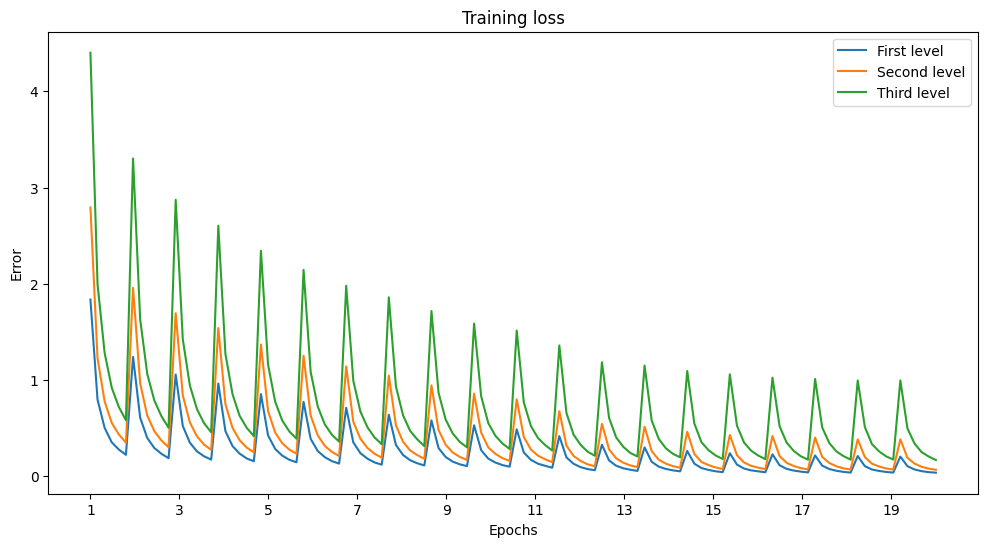

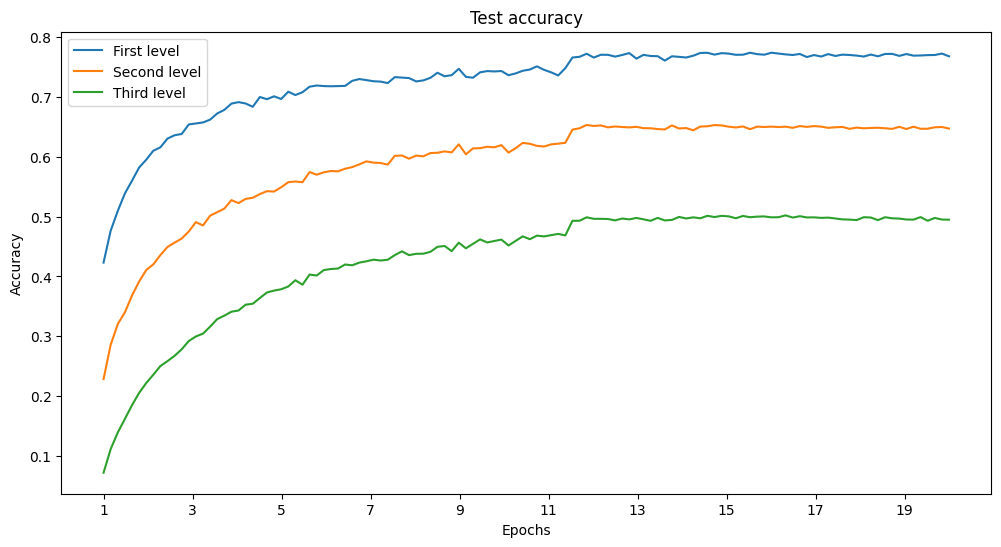

In [7]:
try:
    cnn.train_track(filename)
    cnn.save_model(filename)
    msg = cnn.test(mode = "write", filename = filename)
    cnn.write_configuration(filename, "reinforce, reduction = none, second switch: 14")
    
except Exception as errore:
    err = errore

if err is False:
    bot.sendMessage("Programma terminato correttamente\n\n\nPerformance:\n\n"+msg)
else:
    bot.sendMessage("Programma NON terminato correttamente\nTipo di errore: "+err.__class__.__name__+"\nMessaggio: "+str(err))
    raise err